In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Importing useful libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import pandas as pd
import numpy as np
import joblib
import multiprocessing as mp
import json

### Adding some paths to use from which we would be fetching useful modules like '/home/shared/utils' has db_utils module which is used to connect to the server without showing the credentials!!

In [24]:
sys.path.insert(0, os.getcwd())
sys.path.insert(0, '/home/shared/utils')
sys.path.insert(0, '/home/vishal/refactoring_pipeline')

### Helper function has fetch_checking_acct_txns which is used to check which account from all the available accounts of candidate is checking account. Similarly, EDA is used to get plots which are useful to analyse

### Query function is now available where we dont even have to add credentials in the python dile to establish connection It uses a yaml config file to establish connection.

In [38]:
from db_utils import *
from helper import fetch_checking_acct_txns
import EDA as eda
import query as q

### NCPU is for multiprocessing. The function below takes all the CPU cores available in the system except 2 and if the system only has 2 cores, it uses only one of the cores to perform operations!!(FUn fact:The server which we are working on has 16 spu cores!!)

In [14]:
NCPU = mp.cpu_count() - 2 if mp.cpu_count() > 2 else 1

### Query to fetch required data from iloans!!

In [33]:
def fetch_required_bank_reports(start, end):
    query = f'''
                SELECT
                    LN.LoanId,
                    GCD.TimeAdded,
                    LN.OriginationDate,
                    LN.FirstName,
                    LN.LastName,
                    LN.Campaign,
                    LN.OriginalPrincipal,
                    LN.ReUppedPrincipal,
                    LN.DateOfBirth,
                    LN.BankName,
                    LN.MonthlyGrossIncome,
                    LN.EmployerName,
                    LN.IsFirstDefault,
                    GCD.BankTransactionId,
                    GCD.BankReportData
                FROM view_FCL_Loan LN
                LEFT JOIN view_FCL_GetCreditDataLoan GCDL on LN.LoanId = GCDL.LoanId
                LEFT JOIN view_FCL_GetCreditData GCD on GCD.BankTransactionId = GCDL.BankTransactionId
                WHERE LN.OriginationDate >= {start}
                AND LN.OriginationDate <= {end}
                AND LN.IsFirstDefault IS NOT NULL
                AND LN.MerchantId IN (15, 18)
                AND GCD.ReportStatus  = 'COMPLETE' 
            '''
    df = q.iloans(query)
    return df

### Query to fetch the json data which has all the income related information from bankapp

In [40]:
def fetch_required_bank_app(start, end):
    query = f'''
                SELECT
                    loan_id as LoanId,
                    json
                FROM loan
                WHERE campaign like '%Production%'
                AND STR_TO_DATE(entered_date, '%m/%d/%Y') >= STR_TO_DATE({start}, '%Y-%m-%d')
                AND STR_TO_DATE(entered_date, '%m/%d/%Y') <= STR_TO_DATE({end}, '%Y-%m-%d')
             '''
    df = q.bankapp(query)
    return df

### Fetching the primary checking account coz a candidate may have multiple checking accounts

In [17]:
def get_primary_account(bankreport):
    """
    Flag primary checking account (account having max transaction count)
    
    Args:
    bankreport (json)
    loanid (str)
    
    Returns:
    account number (str) : account number of primary account
    """
    df_txn = fetch_checking_acct_txns(bankreport)
    if df_txn.empty is False:
        df_txns_count = df_txn['account_number'].value_counts()
        return df_txns_count.idxmax()

### We would be working on only those applicants who have atleast 60 days of transactions, from the applied date

In [18]:
def get_transaction_days_count(primary_account, bank_report):
    """Checks if number of transaction days >=60 given an account
    
    Args:
    primary_account (str): Account number of primary account
    bank_report (str): bank report string

    Returns:
    True or False (bool)
    """ 
    df_checking_txns = fetch_checking_acct_txns(bank_report)
    if df_checking_txns.empty is False:
        df_primary_account_txns = df_checking_txns[df_checking_txns['account_number'] == primary_account]
        df_primary_account_txns= df_primary_account_txns.sort_values(by = 'posted_date')
        first_txn_date = df_primary_account_txns['posted_date'].iloc[0]
        last_txn_date = df_primary_account_txns['posted_date'].iloc[-1]
        txn_days_count = (last_txn_date - first_txn_date).days
        return txn_days_count >= 60

### The function below returns all the transactions for a candidate

In [19]:
def get_transaction_time_series(primary_account, bank_report, loan_id):
    """Compute transactions of each day with the dates in timeseries format.

    Args:
    loan_id (float)
    bank_report (str)
    primary_acct (str)

    Returns:
    df_txns(pandas dataframe):
    """
    df_checking_txns = fetch_checking_acct_txns(bank_report)
    if df_checking_txns.empty is False:
        df_txns = df_checking_txns.loc[df_checking_txns['account_number'] == primary_account, :]
        df_txns['posted_date'] = pd.to_datetime(df_txns['posted_date'])
        df_txns['LoanId'] = loan_id
        return df_txns

### This function returns the number of income sources and the income cycle of each income source separated by +. For ex, if income sources are 2, the income cycles would be like in_cycle1+in_cycle2, where in_cycle1 is the income cycle of the first income source and similarly the second part for the second income respectively

In [20]:
def get_income_sources_and_cycle(json_string, loan_id):
    try:
        no_sources = json.loads(json_string)['incomeReview']['data']['incomeSources']
        cycles = []
        for income in range(int(no_sources)):
            cycles.append(json.loads(json_string)['incomeReview']['data']['sources'][income]['incomeCycle'])
        cycles = '+'.join(cycles)
        return [loan_id, no_sources, cycles]
    except:
        return [0, 0, 0]

### The below function checks that if payroll category is present in the candidates transaction, it would return all credit transactions that were not of income type. If we dont find any payroll type category, we would just check all the credit transactions

In [21]:
def get_income(primary_acct, bank_report, loanid):
    test_transact = get_transaction_time_series(primary_acct, bank_report, loanid).sort_values(by = 'posted_date').reset_index(drop = True)
    test_transact['LoanId'] = loanid
    if 'Payroll' in test_transact.category.unique():
        test_inc = test_transact[(test_transact['amount'] > 0) & (test_transact['category'] != 'Income')][['posted_date', 'amount', 'category', 'type', 'memo']]
    else:
        test_inc = test_transact[(test_transact['amount'] > 0)][['posted_date', 'amount', 'category', 'type', 'memo']]
    list_ = test_inc.to_dict('records')
    return list_

### The below function transforms the bank statement like the loan ids are of float type, it coverts it into str type and strips off the date part from timeadded feature

In [22]:
def modify_statement(df):
    """Modifies extracted bank statement data
    Args:
        df (pandas df): Dataframe consisting all the required columns from predicon model database
    Returns:
        pandas df: Modified dataframe
    """
    df['LoanId'] = df['LoanId'].astype(str).map(lambda x : x.split('.')[0])
    df['TimeAdded'] = pd.to_datetime(df['TimeAdded'].map(lambda x : x.date()))
    return df

### The below function converts the transaction statement into 4 buckets based on category of the transactions viz. Payroll, Paycheck, Income or Rest

In [55]:
def get_diff_inc_cat(k):
    txn_proll = txn_pcheq = txn_inc = txn_rest = pd.DataFrame()
    if 'Payroll' in pd.DataFrame(income_temp[k]).groupby('category', as_index = False)['posted_date'].count().nlargest(3, 'posted_date').category.values:
        txn_proll = pd.DataFrame(income_temp[k])[pd.DataFrame(income_temp[k])['category'] == 'Payroll']
    if 'Paycheck' in pd.DataFrame(income_temp[k]).groupby('category', as_index = False)['posted_date'].count().nlargest(3, 'posted_date').category.values:
        txn_pcheq = pd.DataFrame(income_temp[k])[pd.DataFrame(income_temp[k])['category'] == 'Paycheck']
    if 'Income' in pd.DataFrame(income_temp[k]).groupby('category', as_index = False)['posted_date'].count().nlargest(3, 'posted_date').category.values:
        txn_inc = pd.DataFrame(income_temp[k])[pd.DataFrame(income_temp[k])['category'] == 'Income']
    txn_rest = pd.DataFrame(income_temp[k])[(pd.DataFrame(income_temp[k])['category'] != 'Income') & (pd.DataFrame(income_temp[k])['category'] != 'Paycheck') & (pd.DataFrame(income_temp[k])['category'] != 'Payroll')]
    return txn_proll, txn_pcheq, txn_inc, txn_rest

### Fetching bankreports and modifying them, then fetching bankapp data

In [35]:
df_bankreports = fetch_required_bank_reports("'2020-01-07'", "'2020-02-07'")

In [41]:
df_bankapp = fetch_required_bank_app("'2020-01-07'", "'2020-02-07'")

In [42]:
df_bankreports = modify_statement(df_bankreports)

In [ ]:
df_bankreports.sample(5)

In [ ]:
df_bankapp.sample(5)

### Merging the bankapp data with and bankreports

In [43]:
df = pd.merge(df_bankapp, df_bankreports, on = 'LoanId', how = 'inner')

In [44]:
df.sample(5)

,LoanId,json,TimeAdded,OriginationDate,FirstName,LastName,Campaign,OriginalPrincipal,ReUppedPrincipal,DateOfBirth,BankName,MonthlyGrossIncome,EmployerName,IsFirstDefault,BankTransactionId,BankReportData
51,53669760113,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-07,2020-01-09,MARY,STANFILL,F1-LeadPie Eval:16585,300.0,0.0,1973-09-02,"BANK OF AMERICA, N.A.",3000.0,ADVANCED REHABILITATION,False,8f5a75f5-64f3-4390-9a44-f84ecbc16d83,"{""token"":""8f5a75f5-64f3-4390-9a44-f84ecbc16d83..."
277,71672045824,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-22,2020-01-24,Sabina,Bautista,F2-LeapThry Select:43583,150.0,0.0,1966-09-13,WELLS FARGO AND COMPANY,3000.0,Amor,False,f07647cd-ce4b-49fc-8765-6bc25a2b7b05,"{""token"":""f07647cd-ce4b-49fc-8765-6bc25a2b7b05..."
447,72673937387,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-02-04,2020-02-05,Sarah,Zorrilla,F2-StopNGo Select:222,400.0,0.0,1981-04-24,INTERNATIONAL BANK OF COMMERCE,5417.0,Supply chain- hca valley regional medical center,False,dcd35911-6967-4434-a5e3-4ed131fc07a0,"{""token"":""dcd35911-6967-4434-a5e3-4ed131fc07a0..."
127,58670570067,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-12,2020-01-14,Karolyn,Cordell,F2-LeapThry Eval:32902,200.0,0.0,1984-08-23,BANK OF AMERICA N.A.,3000.0,Vasari llc,False,af72d976-7f5f-47df-913f-823a5991ad2a,"{""token"":""af72d976-7f5f-47df-913f-823a5991ad2a..."
420,21673674950,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-02-02,2020-02-04,Kimberly,Buenrostro,Freedom2-ITMedia:123_12476_7,400.0,0.0,1972-09-25,Bank of America,9000.0,Pacsun,False,c1dbb064-083a-442d-96ef-b1837511e60d,"{""token"":""c1dbb064-083a-442d-96ef-b1837511e60d..."


### Using the multiprocessing function to fetch the name of primary checking accounts

In [45]:
with mp.Pool(processes = NCPU) as pool:
        result_primary_accts = pool.map(get_primary_account, df['BankReportData'])
    
df['primary_account'] = result_primary_accts

In [ ]:
df.info()

### Similarly, filtering only those candidates that have atleast 60 transaction days!!

In [46]:
with mp.Pool(processes=NCPU) as pool:
        txn_days_count = pool.starmap(get_transaction_days_count, zip(df['primary_account'], df['BankReportData']))

df['txn_days_count'] = txn_days_count

has_gt_60_days_txns = (df['txn_days_count'] == True)
df = df[has_gt_60_days_txns]

In [ ]:
df.info()

In [47]:
df = df.reset_index(drop = True)

### Fetching the income sources and their cycles respectively

In [48]:
with mp.Pool(processes = NCPU) as pool:
        source_and_cycle = pool.starmap(get_income_sources_and_cycle, zip(df['json'], df['LoanId']))
        
df_source_and_cycle = pd.DataFrame(source_and_cycle, columns = ['LoanId', '#sources', 'in_cycles'])

In [ ]:
df_source_and_cycle.sample(5)

### Merging the sources and cycle data we got to our previously available dataset

In [49]:
df = pd.merge(df, df_source_and_cycle, on = 'LoanId', how = 'left')

In [50]:
df.sample(5)

,LoanId,json,TimeAdded,OriginationDate,FirstName,LastName,Campaign,OriginalPrincipal,ReUppedPrincipal,DateOfBirth,BankName,MonthlyGrossIncome,EmployerName,IsFirstDefault,BankTransactionId,BankReportData,primary_account,txn_days_count,#sources,in_cycles
243,19672082141,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-22,2020-01-24,George,Hernandez,F2-Zero Eval:618031297,250.0,0.0,1969-02-05,WELLS FARGO BANK NA,3500.0,Alameda County,False,d5d90162-5d5a-4a4c-83c8-f11a8066d771,"{""token"":""d5d90162-5d5a-4a4c-83c8-f11a8066d771...",XXXXXX7920,True,NaN,NaN
129,48670897235,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-14,2020-01-15,Paula,Davis,F2Zero4:170917784,400.0,0.0,1963-03-07,"BANK OF AMERICA, N.A.",5000.0,Greater New Bethel,False,9cb92f95-dced-47e9-8efa-70d6b3567459,"{""token"":""9cb92f95-dced-47e9-8efa-70d6b3567459...",Gods-Property---0992,True,1,BiWeekly
300,40672978121,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-29,2020-01-31,CYNTHIA,LEAL,F1Zero4:796217532,250.0,0.0,1974-03-27,"CITIBANK TEXAS, NATIONAL ASSOCIATION",3500.0,Napa Auto Parts,False,b696f8fa-2283-428d-9f83-6c2a0b8db27e,"{""token"":""b696f8fa-2283-428d-9f83-6c2a0b8db27e...",Checking-6457,True,1,BiWeekly
352,28673624189,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-31,2020-02-03,Diego,Morales,F2Zero4:170917784,500.0,0.0,1979-09-02,PLATTE VALLEY STATE BANK & TRUST CO,3500.0,Fresenius,False,75a4cca5-b6a4-4b5b-b8e9-4c965ab187f4,"{""token"":""75a4cca5-b6a4-4b5b-b8e9-4c965ab187f4...",x7669,True,1,BiWeekly
329,55673372616,"{""basicValidations"":{""data"":{""priorLoans"":[{""i...",2020-01-30,2020-01-31,CINDEE,BILLINGSLEY,F2-EPCVIPEval:1333921,300.0,0.0,1970-01-21,J.P. MORGAN CHASE BANK N.A.,3000.0,DE BELLA MECHANICAL,False,b6e64d7f-ef8c-46dd-8c99-2b0d572e9933,"{""token"":""b6e64d7f-ef8c-46dd-8c99-2b0d572e9933...",1008,True,1,Weekly


### Taking a look at how income sources and cycles are distributed accross the loanids

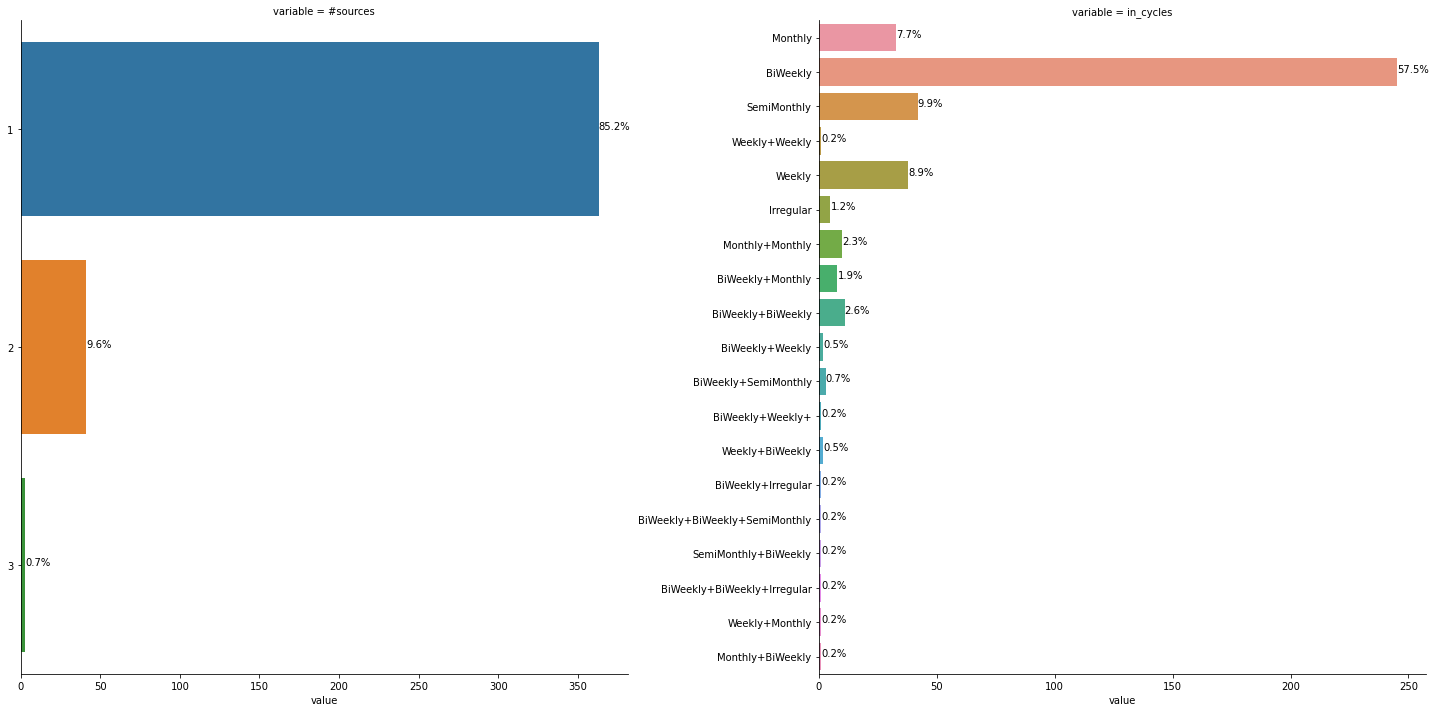

In [51]:
eda.countplot_categorical_columns(df, cols = ['#sources', 'in_cycles'], force = True)

### Fetching required data for a particular index from the dataframe to crossverify things

In [52]:
df.loc[47, ['BankTransactionId', 'primary_account', 'EmployerName', 'LoanId']]

BankTransactionId    2a233507-321f-4ba0-8dfa-573011d22368
primary_account                                      8587
EmployerName                                        Rango
LoanId                                        20669855168
Name: 47, dtype: object

### Checking the json file to see the income status of an applicamt. Here, 47 is the index

In [53]:
json.loads(df.loc[47, 'json'])['incomeReview']['data']

{'que': 'How many income sources are visible?',
 'incomeSources': '2',
 'sources': [{'sourceName': 'RANGO INC        PAYROLL PPD ID: 1260302465',
   'directDeposit': '',
   'records': [{'amount': 1631.52, 'date': '1/3/2020', 'balance': 734.63}]},
  {'incomeCycle': 'Weekly',
   'sourceName': '0190AHKF RANGO I PAYROLL PPD ID: 1454283092',
   'directDeposit': 'Yes',
   'records': [{'amount': 1319.07, 'date': '12/27/2019', 'balance': 399.86},
    {'amount': 1747.13, 'date': '12/20/2019', 'balance': 349.93},
    {'amount': 969.75, 'date': '12/13/2019', 'balance': 448.79},
    {'amount': 1620.38, 'date': '12/6/2019', 'balance': 1205.09},
    {'amount': 568.6, 'date': '11/29/2019', 'balance': 2645.1}]}],
 'incomeTransactions': [{'postedDate': '1/3/2020',
   'memo': 'RANGO INC        PAYROLL PPD ID: 1260302465',
   'categoryName': 'Payroll',
   'amount': 1631.52,
   'endingBalance': 734.63,
   'source': 1,
   'isSelected': True,
   'isRemove': False},
  {'postedDate': '12/31/2019',
   'memo': 

### Using the get_income function to fetch all the required income types

In [54]:
with mp.Pool(processes = NCPU) as pool:
        income_temp = pool.starmap(get_income, zip(df['primary_account'], df['BankReportData'], df['LoanId']))

### An example of how our fetched data looks like

In [ ]:
income_temp[317]

### Loanids which were faulted by manual agents(I think so because they could have a different definition of how an income should behave in the bank statement. may be correct..may be not!!)

<br>81672524189</br>
<br>20669855168</br>

### The income_temp variable is a list of lists of dictionaries. Converting it to dataframe to analyse it rigorously

In [ ]:
pd.DataFrame(income_temp[425]).set_index('posted_date')

### Analysing the buckets returned by get_diff_inc_cat

In [ ]:
txn_proll, txn_pcheq, txn_inc, txn_rest = get_diff_inc_cat(47)

In [ ]:
txn_proll

In [ ]:
txn_inc

In [ ]:
txn_pcheq

In [ ]:
txn_rest

<br>Occurences like business services and music!! causing problems(index425)</br>
<br>Occurences where income comes from 'income' category with electronic deposits are hard to isolate(index152)</br>
<br>Paychecks are always correct</br>
<br>Mostly whenever there are payrolls, income is not but vice versa not true!!</br>